In [18]:
from plotting import imshow
import torch
import torch.nn as nn
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2

In [19]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [20]:
# RGB training data load
yuv_train_set = unpickle('yuv_train')

# Image names 
filenames = [f.decode('utf-8') for f in yuv_train_set[b'filenames']]

# Getting the images
yuv_images_data = yuv_train_set[b'data'].copy() 

In [21]:
def yuv_rgb(array):
    new_array = array.numpy().copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    return torch.tensor((new_array*255).astype(np.uint8)).permute(2, 0, 1)

In [34]:
class YUVImageClassificationDataset(Dataset):
    def __init__(self, filenames, images_data, bin_count=50):
        self.filenames = filenames # image name
        self.images_data = images_data # images data: data used to construct the images 
        self.bin_count = bin_count # number of bins used 
        self.bins = np.linspace(0, 1, bin_count)  # Bin edges
        # we are creating bins between 0 and 1 in order to have the values of u and v

    def __len__(self):
        return len(self.filenames)
    
    def bin_labels(self, values):
        return np.digitize(values, self.bins) -1 # Map values to bin indices
                                                   # This function takes values and assigns each value to a bin index
                                                   # based on self.bins. It returns the index starting from 0

    def __getitem__(self, idx):
        # Creating image from the dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3,32,32)  # (C, H, W)
        img = np.transpose(img, (1, 2, 0))  # (H, W, C)

        # Channel shapes are (H,W)
        Y_channel = img[:, :, 0] / 255.0  # Normalize Y to [0, 1] for stability of the network 
        U_channel = img[:, :, 1] / 255.0   
        V_channel = img[:, :, 2] / 255.0

        # Binned shapes are (H,W)
        U_binned = self.bin_labels(U_channel)  # Discretize U 
        V_binned = self.bin_labels(V_channel)  # Discretize V
        
        # Expanded (1,H,W)
        Y_channel = np.expand_dims(Y_channel, axis=0)

        # Tensor shapes are the same as the array shapes
        Y_channel = torch.tensor(Y_channel, dtype=torch.float32) # transform into tensor to use pytorch 
        U_binned = torch.tensor(U_binned, dtype=torch.int)
        V_binned = torch.tensor(V_binned, dtype=torch.int)
       
        return Y_channel, U_binned, V_binned, self.filenames[idx]



### Creating a lookup table

In [35]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

tensor([ 89, 112,  51], dtype=torch.uint8)
Filename: bos_taurus_s_000507.png


/var/folders/3t/5nmppwwx2p7b5hfgq7bzhzc00000gn/T/ipykernel_9813/1062105336.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32).resize(8,1,32,32)
/Users/mihriban/Desktop/Colorization/.venv/lib/python3.11/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/var/folders/3t/5nmppwwx2p7b5hfgq7bzhzc00000gn/T/ipykernel_9813/1062105336.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32).resize(8,1,32,32)


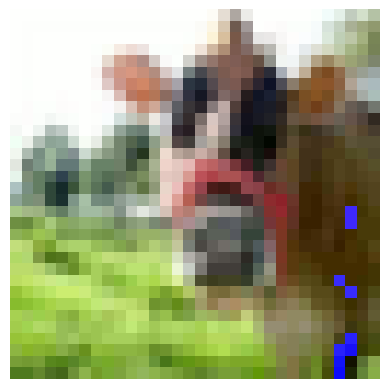

In [36]:

# Loading the RGB images
dataset = YUVImageClassificationDataset(filenames=filenames, images_data=yuv_images_data)
train_loader = DataLoader(dataset, batch_size=8, shuffle = False)

for Y_channel, U_binned, V_binned, fname in train_loader:
    
    U_target_rec = unbin_labels(U_binned.clone().detach())
    U_target_rec_tensor = torch.tensor(U_target_rec, dtype=torch.float32).resize(8,1,32,32)

    V_target_rec = unbin_labels(V_binned.clone().detach())
    V_target_rec_tensor = torch.tensor(V_target_rec , dtype=torch.float32).resize(8,1,32,32)
    
    reconstructed_img = torch.cat([Y_channel,U_target_rec_tensor,V_target_rec_tensor],dim=1)

    image_yuv = reconstructed_img[0]  # Frist image of the batch (YUV)

    # Need to resize first
    rgb_output = yuv_rgb(image_yuv.resize(32, 32,3))
    print(rgb_output[:,30,30])

    print(f"Filename: {fname[0]}")

    imshow(rgb_output) 
    
    
    break

In [ ]:
# --- SIMPLIFIED NETWORK -------------


# ----- CLASSIFICATION CNN MODEL -----
class ClassificationCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(ClassificationCNN, self).__init__()
        
        # Initial Convolutional Layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        
        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # Skip Connections
        self.skip0 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        
        self.conv_final = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU()
        )
        
        # Output Layers for Classification
        self.output_U = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.output_V = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1_pooled = self.pool1(x1)
        
        x2 = self.conv2(x1_pooled)
        x2_pooled = self.pool2(x2)
        x2_pooled_padded = F.interpolate(x2_pooled, size=(32, 32), mode='bilinear', align_corners=False)

        x1_conv = self.skip0(x1)
        x2_padded = F.interpolate(x2, size=(32, 32), mode='bilinear', align_corners=False)
        el_wise = x1_conv + x2_padded
        
        # Concatenation layer
        x_concat = torch.cat([el_wise, x2_pooled_padded], dim=1) # necessitano solo stessa H e W

        # Final convolutional processing
        x_final = self.conv_final(x_concat)

        U_out = self.output_U(x_final)
        V_out = self.output_V(x_final)

        return U_out, V_out